In [9]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-e8338ed0-7ac1-cda0-0f24-7202a88c6c23)


In [10]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [11]:
import tensorflow as tf
print(tf.__version__)

2.8.0


In [12]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-05-06 02:18:45--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-05-06 02:18:45 (89.6 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [61]:
import tensorflow as tf

# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.image.decode_jpeg(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")
  
# Make a function to predict on images and plot them (works with multi-class)
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);
  
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instand to store log files.

  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"

  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

# Plot the validation and training data separately
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two TensorFlow model History objects.
    
    Args:
      original_history: History object from original model (before new_history)
      new_history: History object from continued model training (after original_history)
      initial_epochs: Number of epochs in original_history (new_history plot starts from here) 
    """
    
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()
  
# Create function to unzip a zipfile into current working directory 
# (since we're going to be downloading and unzipping a few files)
import zipfile

def unzip_data(filename):
  """
  Unzips filename into the current working directory.

  Args:
    filename (str): a filepath to a target zip folder to be unzipped.
  """
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()

# Walk through an image classification directory and find out how many files (images)
# are in each subdirectory.
import os

def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.

  Args:
    dir_path (str): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
    
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [13]:
import tensorflow_datasets as tfds

In [14]:
datasets_list = tfds.list_builders()
print("food101" in datasets_list)

True


In [15]:
(train_data, test_data), ds_info = tfds.load(name = "food101",
                                             split = ["train", "validation"],
                                             shuffle_files = True,
                                             as_supervised = True,
                                             with_info = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteO5KXND/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteO5KXND/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [16]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [17]:
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [18]:
train_one_example = train_data.take(1)

In [19]:
train_one_example

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [20]:
for image, label in train_one_example:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name : {class_names[label.numpy()]}""")


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 56
  Class name : huevos_rancheros


In [21]:
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[233, 253, 251],
        [231, 253, 250],
        [228, 254, 251],
        ...,
        [ 85,  82,  89],
        [ 68,  67,  75],
        [ 57,  57,  67]],

       [[232, 254, 252],
        [229, 254, 251],
        [226, 255, 251],
        ...,
        [121, 116, 120],
        [100,  99, 104],
        [ 86,  85,  91]],

       [[228, 254, 253],
        [226, 255, 253],
        [223, 255, 252],
        ...,
        [164, 159, 155],
        [145, 141, 138],
        [128, 127, 125]],

       ...,

       [[ 66, 112, 164],
        [ 67, 113, 163],
        [ 55,  99, 148],
        ...,
        [  5,  14,  23],
        [  9,  18,  27],
        [  8,  17,  26]],

       [[ 76, 123, 177],
        [ 75, 122, 176],
        [ 70, 116, 168],
        ...,
        [  5,  14,  23],
        [  9,  18,  25],
        [  7,  16,  23]],

       [[ 80, 129, 185],
        [ 71, 121, 174],
        [ 74, 121, 175],
        ...,
        [  7,  16,  2

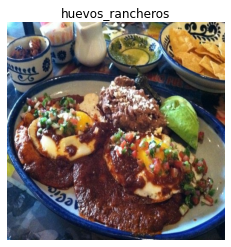

In [22]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

In [23]:
tf.reduce_min(image)

<tf.Tensor: shape=(), dtype=uint8, numpy=0>

In [24]:
tf.reduce_max(image)

<tf.Tensor: shape=(), dtype=uint8, numpy=255>

In [25]:
def preprocess_img(image,label, img_shape=224):

  image = tf.image.resize(image, [img_shape, img_shape])
  return tf.cast(image, tf.float32), label

In [26]:
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape}")

Image before preprocessing:
 [[[233 253 251]
  [231 253 250]
  [228 254 251]
  ...
  [ 85  82  89]
  [ 68  67  75]
  [ 57  57  67]]

 [[232 254 252]
  [229 254 251]
  [226 255 251]
  ...
  [121 116 120]
  [100  99 104]
  [ 86  85  91]]]...,
Shape: (512, 512, 3)

Image after preprocessing:
 [[[230.65816  253.64285  251.      ]
  [222.99998  254.97449  252.19388 ]
  [207.06633  255.       250.36734 ]
  ...
  [140.66287  129.52519  121.22428 ]
  [121.14268  115.265144 116.95397 ]
  [ 83.95363   83.08119   89.63737 ]]

 [[221.47449  254.37755  253.33163 ]
  [214.5102   255.       253.92348 ]
  [198.41327  254.58673  251.96939 ]
  ...
  [208.66318  195.82143  173.40823 ]
  [197.03056  190.1071   174.83162 ]
  [175.54036  171.6169   161.21384 ]]]...,
Shape: (224, 224, 3)


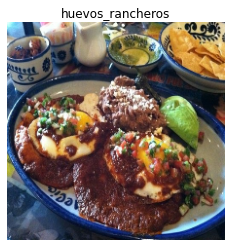

In [30]:
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False);

In [34]:
train_data = train_data.map(map_func = preprocess_img, num_parallel_calls = tf.data.AUTOTUNE)

train_data = train_data.shuffle(buffer_size = 1000).batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)

test_data = test_data.map(map_func = preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

test_data = test_data.batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)

In [35]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [36]:
test_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [44]:

checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor = "val_accuracy",
                                                      save_best_only = True,
                                                      save_weights_only = True,
                                                      verbose = 1)

In [50]:
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy("mixed_float16")

In [46]:
!nvidia-smi

Fri May  6 04:08:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    28W /  70W |    266MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [49]:
mixed_precision.global_policy()

<Policy "mixed_float16">

In [51]:
len(class_names)

101

In [53]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

inputs = layers.Input(shape = input_shape, name = "input_layer", dtype = tf.float16)

x = base_model(inputs, training = False)
x = layers.GlobalAveragePooling2D(name = "pooling_layer")(x)
x = layers.Dense(len(class_names))(x)

outputs = layers.Activation("softmax", dtype = tf.float32, name = "softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

model.compile(loss = "sparse_categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ["accuracy"])

16719872/16705208 [==============================] - 0s 0us/step


In [54]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [56]:
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float16 <Policy "float16">
efficientnetb0 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [57]:
for layer in model.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False flo

In [63]:
history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs= 3,
                                                     steps_per_epoch = len(train_data),
                                                     validation_data = test_data,
                                                     validation_steps = int(0*15 * len(test_data)),
                                                     callbacks = [create_tensorboard_callback("training_logs",
                                                                                              "efficientnetb0_101_classes_all_data_feature_extract"),
                                                                  model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20220506-050206
Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 1.8211 - accuracy: 0.5572WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


2368/2368 [==============================] - 206s 78ms/step - loss: 1.8211 - accuracy: 0.5572
Epoch 2/3
2368/2368 [==============================] - ETA: 0s - loss: 1.2935 - accuracy: 0.6662WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


2368/2368 [==============================] - 185s 77ms/step - loss: 1.2935 - accuracy: 0.6662
Epoch 3/3
2368/2368 [==============================] - ETA: 0s - loss: 1.1436 - accuracy: 0.7016WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


2368/2368 [==============================] - 183s 76ms/step - loss: 1.1436 - accuracy: 0.7016


In [64]:
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 58s 69ms/step - loss: 1.0841 - accuracy: 0.7096


[1.0841343402862549, 0.7096237540245056]

In [65]:
save_dir = "07_efficientnetb0_feature_extract_model_mixed_precision"
model.save(save_dir)

INFO:tensorflow:Assets written to: 07_efficientnetb0_feature_extract_model_mixed_precision/assets


INFO:tensorflow:Assets written to: 07_efficientnetb0_feature_extract_model_mixed_precision/assets


In [66]:
loaded_saved_model = tf.keras.models.load_model(save_dir)

In [67]:
for layer in loaded_saved_model.layers[1].layers[:20]: 
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False floa

In [68]:
results_loaded_saved_model = loaded_saved_model.evaluate(test_data)
results_loaded_saved_model

790/790 [==============================] - 57s 69ms/step - loss: 1.0841 - accuracy: 0.7096


[1.0841349363327026, 0.7096237540245056]

In [72]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",patience = 3)

checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only = True,
                                                      monitor = "val_loss")

In [73]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss",
                                                 factor = 0.2,
                                                 patience =2,
                                                 verbose = 1,
                                                 min_lr = 1e-7)

In [75]:
model_extra = model

In [76]:
model.compile(loss="sparse_categorical_crossentropy",
                                   optimizer = tf.keras.optimizers.Adam(0.0001),
                                   metrics = ["accuracy"])

In [77]:
history_101_food_classes_fine_tune = model.fit(train_data,
                                               epochs = 100,
                                               steps_per_epoch = len(train_data),
                                               validation_data = test_data,
                                               validation_steps = int(0.15 * len(test_data)),
                                               callbacks = [model_checkpoint,early_stopping,reduce_lr])

Epoch 1/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.9720 - accuracy: 0.7520INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


2368/2368 [==============================] - 247s 99ms/step - loss: 0.9720 - accuracy: 0.7520 - val_loss: 1.0533 - val_accuracy: 0.7214 - lr: 1.0000e-04
Epoch 2/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.9552 - accuracy: 0.7565INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


2368/2368 [==============================] - 236s 99ms/step - loss: 0.9553 - accuracy: 0.7564 - val_loss: 1.0452 - val_accuracy: 0.7219 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - 185s 77ms/step - loss: 0.9443 - accuracy: 0.7599 - val_loss: 1.0458 - val_accuracy: 0.7209 - lr: 1.0000e-04
Epoch 4/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.9347 - accuracy: 0.7629
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 185s 77ms/step - loss: 0.9347 - accuracy: 0.7630 - val_loss: 1.0453 - val_accuracy: 0.7238 - lr: 1.0000e-04
Epoch 5/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.9174 - accuracy: 0.7682INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


2368/2368 [==============================] - 237s 99ms/step - loss: 0.9174 - accuracy: 0.7682 - val_loss: 1.0430 - val_accuracy: 0.7233 - lr: 2.0000e-05
Epoch 6/100
2368/2368 [==============================] - 186s 78ms/step - loss: 0.9152 - accuracy: 0.7686 - val_loss: 1.0444 - val_accuracy: 0.7246 - lr: 2.0000e-05
Epoch 7/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.9135 - accuracy: 0.7689INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets



Epoch 7: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
2368/2368 [==============================] - 235s 99ms/step - loss: 0.9135 - accuracy: 0.7689 - val_loss: 1.0429 - val_accuracy: 0.7243 - lr: 2.0000e-05
Epoch 8/100
2368/2368 [==============================] - 184s 77ms/step - loss: 0.9098 - accuracy: 0.7707 - val_loss: 1.0487 - val_accuracy: 0.7230 - lr: 4.0000e-06
Epoch 9/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.9094 - accuracy: 0.7707
Epoch 9: ReduceLROnPlateau reducing learning rate to 7.999999979801942e-07.
2368/2368 [==============================] - 187s 78ms/step - loss: 0.9094 - accuracy: 0.7707 - val_loss: 1.0460 - val_accuracy: 0.7238 - lr: 4.0000e-06
Epoch 10/100
2368/2368 [==============================] - 190s 80ms/step - loss: 0.9086 - accuracy: 0.7708 - val_loss: 1.0438 - val_accuracy: 0.7240 - lr: 8.0000e-07


In [78]:
save_dir2 = "Final_model_Food101"
model.save(save_dir2)

INFO:tensorflow:Assets written to: Final_model_Food101/assets


INFO:tensorflow:Assets written to: Final_model_Food101/assets


In [79]:
model.evaluate(test_data)

790/790 [==============================] - 57s 72ms/step - loss: 1.0414 - accuracy: 0.7203


[1.0414360761642456, 0.7202772498130798]

In [80]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
unzip_data("custom_food_images.zip")

--2022-05-06 07:07:54--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.139.128, 108.177.12.128, 74.125.26.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.139.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  82.0MB/s    in 0.2s    

2022-05-06 07:07:54 (82.0 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [82]:
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/chicken_wings.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/pizza-dad.jpeg']

In [84]:

def load_and_prep_image(filename, img_shape=224, scale = True):
  img = tf.io.read_file(filename)
  img = tf.io.decode_image(img)
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    return img/255.
  else:
    return img

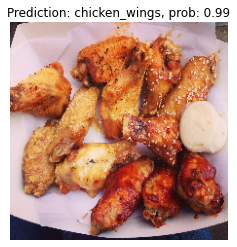

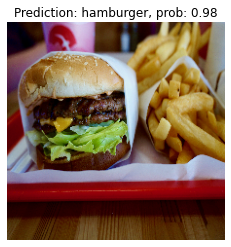

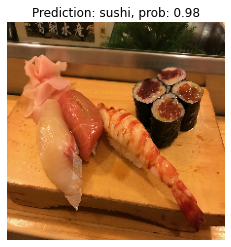

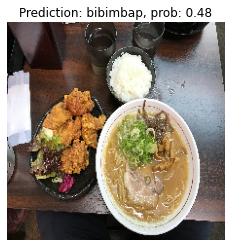

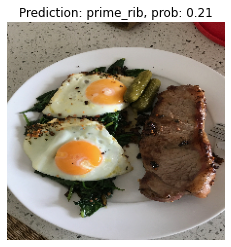

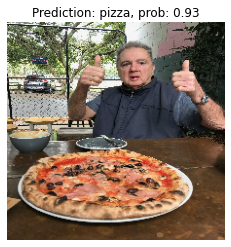

In [89]:
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False)
  pred_prob = model.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[pred_prob.argmax()]
  plt.figure()
  plt.imshow(img/255.)
  plt.title(f"Prediction: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)